### Imports

In [1]:
# imporrs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import json
import os
import logging

from sklearn.linear_model import Lasso
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    root_mean_squared_error
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)
from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import custom_estimators as cust_est

plt.style.use("dark_background")
pd.pandas.set_option("display.max_columns", None)
logging.basicConfig(filename=os.path.join("final_pipeline_output", "metrics.log"), level=logging.INFO)

### Config variables

In [2]:
# load in the config json file
with open("config_file.json") as f:
    config = json.load(f)

### Load the dataset

In [3]:
# load dataset
data = pd.read_csv("train.csv")

# rows and columns of the data
print(data.shape)

# cast to type object
for cat in config["CATEGORICAL_VARS"]:
    data[cat] = data[cat].astype("object")

# create train test split
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(["Id", "SalePrice"], axis=1),
    data["SalePrice"],
    test_size=0.1, 
    random_state=87,
)

# rows and columns of the train test sets
print(X_train.shape, X_test.shape)

(1460, 81)
(1314, 79) (146, 79)


### Target transformation

In [4]:
# create log transformation
y_train, y_test = np.log(y_train), np.log(y_test)

### Select relevant features

In [5]:
# select relevant features
X_train, X_test = X_train[config["FEATURES"]], X_test[config["FEATURES"]]

### Create Pipeline

In [6]:
price_pipe = Pipeline([

    # IMPUTATIONS
    (
        "missing_imputation", CategoricalImputer(
        imputation_method="missing", variables=config["CATEGORICAL_VARS_WITH_NA_MISSING"])
    ),

    (
        "frequent_imputation", CategoricalImputer(
        imputation_method="frequent", variables=config["CATEGORICAL_VARS_WITH_NA_FREQUENT"])
    ),

    (
        "missing_indicator", AddMissingIndicator(variables=config["NUMERICAL_VARS_WITH_NA"])
    ),

    (
        "mean_imputation", MeanMedianImputer(
        imputation_method="mean", variables=config["NUMERICAL_VARS_WITH_NA"])
    ),
    
    
    # TEMPORAL VARIABLES
    (
        "elapsed_time", cust_est.TemporalVariableTransformer(
        variables=config["TEMPORAL_VARS"], reference_variable=config["REF_VAR"])
    ),

    (
        "drop_features", DropFeatures(features_to_drop=config["DROP_FEATURES"])
    ),

    # VARIABLE TRANSFORMATION
    (
        "log", LogTransformer(variables=config["NUMERICALS_LOG_VARS"])
    ),
    
    (
        "binarizer", SklearnTransformerWrapper(
        transformer=Binarizer(threshold=0), variables=config["BINARIZE_VARS"])
    ),
    
    # mappers
    (
        "mapper_qual", cust_est.Mapper(
        variables=config["QUAL_VARS"], mappings=config["QUAL_MAPPINGS"])
    ),

    (
        "mapper_exposure", cust_est.Mapper(
        variables=config["EXPOSURE_VARS"], mappings=config["EXPOSURE_MAPPINGS"])
    ),

    (
        "mapper_finish", cust_est.Mapper(
        variables=config["FINISH_VARS"], mappings=config["FINISH_MAPPINGS"])
    ),

    (
        "mapper_garage", cust_est.Mapper(
        variables=config["GARAGE_VARS"], mappings=config["GARAGE_MAPPINGS"])
    ),
    
    #CATEGORICAL ENCODING
    (
        "rare_label_encoder", RareLabelEncoder(
        tol=0.01, n_categories=1, variables=config["CATEGORICAL_VARS"])
    ),

    (
        "categorical_encoder", OrdinalEncoder(
        encoding_method="ordered", variables=config["CATEGORICAL_VARS"])
    ),
    
    # SCALING
    (
        "scaler", MinMaxScaler()
    ),

    # MODEL
    (
        "Lasso", Lasso(alpha=0.001, random_state=0)
    ),
])

In [7]:
price_pipe.fit(X_train, y_train)

Pipeline(steps=[('missing_imputation',
                 CategoricalImputer(variables=['FireplaceQu'])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtQual', 'BsmtExposure',
                                               'BsmtFinType1',
                                               'GarageFinish'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['LotFrontage'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method=...
                                             'Exterior1st', 'Foundation',
                                             'CentralAir', 'Functional',
                                             'PavedDrive', 'SaleCondition'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['MSZoning', 'LotShape',
                                           'LandContour', 'LotConfig',
                                           'Neighborhood', 'RoofStyle',
                                           'Exterior1st', 'Foundation',
                                           'CentralAir', 'Functional',
                                           'PavedDrive', 'SaleCondition'])),
                ('scaler', MinMaxScaler()),
                ('Lasso', Lasso(alpha=0.001, random_state=0))])

In [8]:
# make predictions for train set
pred = price_pipe.predict(X_train)

# determine mse, rmse and r2
logging.info("train mse: {}".format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
logging.info("train rmse: {}".format(int(
    root_mean_squared_error(np.exp(y_train), np.exp(pred)))))
logging.info("train r2: {}".format(
    r2_score(np.exp(y_train), np.exp(pred))))

# make predictions for test set
pred = price_pipe.predict(X_test)

# determine mse, rmse and r2
logging.info("test mse: {}".format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
logging.info("test rmse: {}".format(int(
    root_mean_squared_error(np.exp(y_test), np.exp(pred)))))
logging.info("test r2: {}".format(
    r2_score(np.exp(y_test), np.exp(pred))))

# derermine average house price
logging.info("Average house price: {}".format(int(np.exp(y_train).median())))

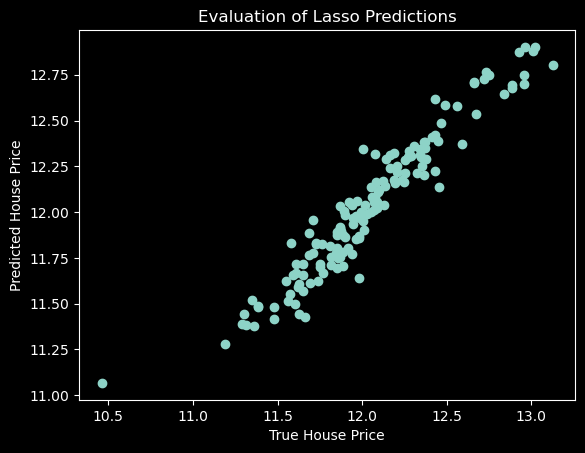

<Figure size 640x480 with 0 Axes>

In [9]:
# let's evaluate our predictions respect to the real sale price
plt.scatter(y_test, price_pipe.predict(X_test))
plt.xlabel("True House Price")
plt.ylabel("Predicted House Price")
plt.title("Evaluation of Lasso Predictions")
plt.savefig(os.path.join("final_pipeline_output","lasso_price_evaluation.png"), format="png")
plt.show()

In [10]:
# now let's save the pipeline
joblib.dump(price_pipe, os.path.join("final_pipeline_output", "price_pipe.joblib"))

['final_pipeline_output/price_pipe.joblib']